In [3]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import math
import numpy as np
import datetime
from time import time
from functools import reduce
from matplotlib import pyplot as plt
from soccerlearn.features import *
from soccerlearn.data import LocalRawDataRepository
    
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)


SMALL_SIZE=17
MEDIUM_SIZE=SMALL_SIZE+5
BIGGER_SIZE=MEDIUM_SIZE+5

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('figure', dpi=200)

league_to_files = {
    'La Liga': {
        'standings': '../data/standings_La Liga.csv',        
        'seasons': '../data/seasons.csv',
        'teams': '../data/teams_league_La Liga.csv',
        'fixtures': '../data/fixtures_and_odds_La Liga_2000-07-01_2020-07-01.csv',
    },
    'Premier League': {
        'standings': '../data/standings_Premier League.csv',
        'seasons': '../data/seasons.csv',
        'teams': '../data/teams_league_Premier League.csv',
        'fixtures': '../data/fixtures_and_odds_Premier League_2014-07-01_2020-07-01.csv',    
    },
}

features = []

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
league_name = 'La Liga'
start_date = '2000-07-01'
end_date = '2020-07-01'
repo = LocalRawDataRepository(path='../data/')
data = repo.read_data(league_name, start_date, end_date)

In [8]:
def rename_columns(data):
    data['seasons'] = data['seasons'].rename(columns={'id': 'season_id', 'name': 'season_name'})
    return data
    
def process_fixtures(data):
    fixtures_and_odds = pd.merge(data['fixtures'], data['seasons'][['season_id', 'season_name']], on='season_id', how='left')
    fixtures_and_odds['season_start_year'] = fixtures_and_odds['season_name'].apply(lambda x: x.split('/')[0])
    fixtures_and_odds['date_time'] = pd.to_datetime(fixtures_and_odds['time'].apply(lambda x: eval(x)['starting_at']['date_time']))
    fixtures_and_odds['year'] = fixtures_and_odds['date_time'].dt.year
    fixtures_and_odds['month'] = fixtures_and_odds['date_time'].dt.month
    fixtures_and_odds['date'] = pd.to_datetime(fixtures_and_odds['date_time'].dt.date)
    fixtures_and_odds['round_id'] = fixtures_and_odds['round_id'].apply(lambda x: np.nan if math.isnan(x) else str(int(x)))
    data['fixtures'] = fixtures_and_odds
    return data

def add_h2h_id_to_fixtures(data):
    data['fixtures']['h2h_id'] = data['fixtures'].apply(lambda x: '_'.join(map(str, sorted([x['localteam_id'], x['visitorteam_id']]))), axis=1)
    return data


In [12]:
team_date_pipeline =  Pipeline([
    (None, rename_columns, {}),
    (None, process_fixtures, {}),    
    (None, add_h2h_id_to_fixtures, {}),    
    (None, unpivot_fixtures_by_odds, {'multiple_bookmakers': False}),
    ('pivot_fixtures_by_team', pivot_fixtures_by_team, {}),
    ('get_scores', get_scores, {}),
    ('get_results', get_results,{}),
    ('get_games_played', get_games_played_current_season, {}),
    ('get_cumulative_results', get_cumulative_results_current_season, {}),
    ('get_winning_odds', get_winning_odds, {}),
    ('h2h_features', get_h2h_features, {}),
    ('rolling_results_5', get_rolling_results, {'periods': 5, 'agg_func': 'mean'}),
    ('rolling_results_15', get_rolling_results, {'periods': 15, 'agg_func': 'mean'}),
    ('rolling_results_10_ewm', get_rolling_results, {'periods': 10, 'agg_func': 'ewm'}),
])


meta_pipeline = Pipeline([
    ('fixture_features', team_date_pipeline, {}),
    #('team_season', team_season_pipeline, {})
])


fixture_features = team_date_pipeline.transform(data)
fixture_features.head()

KeyError: 'Column not found: win'

In [ ]:
data['fixture_features'] = fixture_features
team_season_pipeline =  Pipeline([
    ('positions', compute_position_end_season, {}),
    ('previous_season', compute_previous_season_features, {}),
    #('transfers', get_amount_transferred, {}),
])


team_season_features = team_season_pipeline.transform(data)

In [37]:
team_season_features.head()

position_end_season  goals_scored_current_season_lag_1  \
team_id season_id                                                           
36      853                         13                                NaN   
        2052                         6                               51.0   
        2053                        18                               44.0   
        2059                        17                               38.0   
        2060                         9                               36.0   

                   points_current_season_lag_1  \
team_id season_id                                
36      853                                NaN   
        2052                              44.0   
        2053                              61.0   
        2059                              36.0   
        2060                              34.0   

                   goals_conceded_current_season_lag_1  \
team_id season_id                                        
36      853                                        NaN   
        2052                                      67.0   
        2053                                      33.0   
        2059                                      58.0   
        2060                                      52.0   

                   position_end_season_lag_1  
team_id season_id                             
36      853                              NaN  
        2052                            13.0  
        2053                             6.0  
        2059                            18.0  
        2060                            17.0

In [17]:
teams = pd.read_csv(league_to_files[league_name]['teams'])
teams = teams.rename(columns={'id': 'team_id'}).groupby('team_id')[['name', 'short_code']].first()
fixture_features = fixture_features.join(teams, how='left').sort_index()
teams.index = teams.index.rename('opposite_team_id')
fixture_features = fixture_features.reset_index().set_index('opposite_team_id').join(teams, how='left', rsuffix='_opposite')
data['fixture_features'] = fixture_features

team_season_pipeline =  Pipeline([
    ('positions', compute_position_end_season, {}),
    ('previous_season', compute_previous_season_features, {}),
    #('transfers', get_amount_transferred, {}),
])


team_season_features = team_season_pipeline.transform(data)

fixture_features = pd.merge(
    fixture_features.reset_index(),
    team_season_features.reset_index(),
    on=['team_id', 'season_id'],
    how='left',
).set_index(['team_id', 'date'])
fixture_features['league'] = 'La Liga'
features.append(fixture_features)
print(fixture_features.shape)
fixture_features.head()


Creating feature pivot_fixtures_by_team
Creating feature get_scores
Creating feature get_results
Creating feature get_games_played
Creating feature get_cumulative_results
Creating feature get_winning_odds
Creating feature h2h_features
Creating feature rolling_results_5
Creating feature rolling_results_15
Creating feature rolling_results_10_ewm
Pipeline finished
Creating feature positions
Creating feature previous_season
Pipeline finished
(11378, 59)


opposite_team_id round_id  \
team_id date                                    
60      2014-11-29                36    54990   
        2015-04-19                36    55324   
        2015-09-26                36    55278   
        2016-02-20                36    55454   
        2016-11-19                36    27685   

                                                               scores  \
team_id date                                                            
60      2014-11-29  {'localteam_score': 0, 'visitorteam_score': 1,...   
        2015-04-19  {'localteam_score': 0, 'visitorteam_score': 1,...   
        2015-09-26  {'localteam_score': 1, 'visitorteam_score': 1,...   
        2016-02-20  {'localteam_score': 3, 'visitorteam_score': 2,...   
        2016-11-19  {'localteam_score': 1, 'visitorteam_score': 0,...   

                    winner_team_id  season_id season_start_year h2h_id  \
team_id date                                                             
60      2014-11-29            60.0       2061              2014  36_60   
        2015-04-19            36.0       2061              2014  36_60   
        2015-09-26             NaN       2063              2015  36_60   
        2016-02-20            36.0       2063              2015  36_60   
        2016-11-19            60.0        853              2016  36_60   

                    winning_odds_calculated  odd_value_1  odd_value_2  ...  \
team_id date                                                           ...   
60      2014-11-29                     True          NaN          NaN  ...   
        2015-04-19                     True          NaN          NaN  ...   
        2015-09-26                     True          NaN          NaN  ...   
        2016-02-20                     True          NaN          NaN  ...   
        2016-11-19                     True          NaN          NaN  ...   

                        name  short_code  name_opposite  short_code_opposite  \
team_id date                                                                   
60      2014-11-29  SD Eibar         EIB  Celta de Vigo                  CLV   
        2015-04-19  SD Eibar         EIB  Celta de Vigo                  CLV   
        2015-09-26  SD Eibar         EIB  Celta de Vigo                  CLV   
        2016-02-20  SD Eibar         EIB  Celta de Vigo                  CLV   
        2016-11-19  SD Eibar         EIB  Celta de Vigo                  CLV   

                    position_end_season  goals_scored_current_season_lag_1  \
team_id date                                                                 
60      2014-11-29                   16                               54.0   
        2015-04-19                   16                               54.0   
        2015-09-26                   13                               31.0   
        2016-02-20                   13                               31.0   
        2016-11-19                   10                                NaN   

                    points_current_season_lag_1  \
team_id date                                      
60      2014-11-29                         54.0   
        2015-04-19                         54.0   
        2015-09-26                         32.0   
        2016-02-20                         32.0   
        2016-11-19                          NaN   

                   goals_conceded_current_season_lag_1  \
team_id date                                             
60      2014-11-29                                47.0   
        2015-04-19                                47.0   
        2015-09-26                                55.0   
        2016-02-20                                55.0   
        2016-11-19                                 NaN   

                   position_end_season_lag_1   league  
team_id date                                           
60      2014-11-29                      10.0  La Liga  
        2015-04-19                      10.0  La Liga  
 

In [34]:

team_season_pipeline =  Pipeline([
    ('positions', compute_position_end_season, {}),
    ('previous_season', compute_previous_season_features, {}),
    #('transfers', get_amount_transferred, {}),
])


team_season_features = team_season_pipeline.transform(data)

Creating feature positions
Creating feature previous_season


KeyError: 'fixture_features'

In [4]:
#league_name = 'Premier League'
#season_data = pd.read_csv(league_to_files[league_name]['seasons']).rename(columns={'id': 'season_id', 'name': 'season_name'})
#team_data = pd.read_csv(league_to_files[league_name]['teams'])
#fixtures_and_odds = pd.read_csv(league_to_files[league_name]['fixtures'])
#fixtures_and_odds = pd.merge(fixtures_and_odds, season_data[['season_id', 'season_name']], on='season_id', how='left')
#fixtures_and_odds['season_start_year'] = fixtures_and_odds['season_name'].apply(lambda x: x.split('/')[0])
#fixtures_and_odds['date_time'] = pd.to_datetime(fixtures_and_odds['time'].apply(lambda x: eval(x)['starting_at']['date_time']))
#fixtures_and_odds['year'] = fixtures_and_odds['date_time'].dt.year
#fixtures_and_odds['month'] = fixtures_and_odds['date_time'].dt.month
#fixtures_and_odds['date'] = pd.to_datetime(fixtures_and_odds['date_time'].dt.date)
#fixtures_and_odds['round_id'] = fixtures_and_odds['round_id'].apply(lambda x: np.nan if math.isnan(x) else str(int(x)))
#date_to_season = fixtures_and_odds.groupby('date')[['season_id']].first()
#standings_data = pd.read_csv(league_to_files[league_name]['standings'])
#data = {'fixtures': fixtures_and_odds, 'standings': standings_data, 'teams': team_data}
#data['fixtures'] = unpivot_fixtures_by_odds(data)
#data['fixtures']['h2h_id'] = data['fixtures'].apply(lambda x: '_'.join(map(str, sorted([x['localteam_id'], x['visitorteam_id']]))), axis=1)
#
#
#team_date_pipeline =  Pipeline([
#    ('pivot_fixtures_by_team', pivot_fixtures_by_team, {}),
#    ('get_scores', get_scores, {}),
#    ('get_results', get_results, {}),
#    ('get_games_played', get_games_played_current_season, {}),
#    ('get_cumulative_results', get_cumulative_results_current_season, {}),
#    ('get_winning_odds', get_winning_odds, {}),
#    ('h2h_features', get_h2h_features, {}),
#    ('rolling_results_5', get_rolling_results, {'periods': 5, 'agg_func': 'mean'}),
#    ('rolling_results_15', get_rolling_results, {'periods': 15, 'agg_func': 'mean'}),
#    ('rolling_results_10_ewm', get_rolling_results, {'periods': 10, 'agg_func': 'ewm'}),
#])
#fixture_features = team_date_pipeline.transform(data)
#
#teams = pd.read_csv(league_to_files[league_name]['teams'])
#teams = teams.rename(columns={'id': 'team_id'}).groupby('team_id')[['name', 'short_code']].first()
#fixture_features = fixture_features.join(teams, how='left').sort_index()
#teams.index = teams.index.rename('opposite_team_id')
#fixture_features = fixture_features.reset_index().set_index('opposite_team_id').join(teams, how='left', rsuffix='_opposite')
#data['fixture_features'] = fixture_features
#
#team_season_pipeline =  Pipeline([
#    ('positions', compute_position_end_season, {}),
#    ('previous_season', compute_previous_season_features, {}),
#    #('transfers', get_amount_transferred, {}),
#])
#team_season_features = team_season_pipeline.transform(data)
#
#fixture_features = pd.merge(
#    fixture_features.reset_index(),
#    team_season_features.reset_index(),
#    on=['team_id', 'season_id'],
#    how='left',
#).set_index(['team_id', 'date'])
#fixture_features['league'] = 'Premier League'
#features.append(fixture_features)
#print(fixture_features.shape)
#fixture_features.head()
#

In [5]:
#fixture_features = pd.concat(features)

## Feature engineering

In [18]:
def add_difference_features(data, feature_names):
    for name in feature_names:
        data[f'difference_in_{name}'] = data[f'local_{name}'] - data[f'visitor_{name}']
        
    return data

In [19]:
feature_matrix = data['fixtures'].copy()
feature_matrix['date'] = pd.to_datetime(feature_matrix['date'])
feature_matrix = pd.merge(
    feature_matrix,
    fixture_features.add_prefix('local_').reset_index().rename(columns={'team_id': 'localteam_id'}),
    on=['localteam_id', 'date'],
    how='left'
)
feature_matrix = pd.merge(
    feature_matrix,
    fixture_features.add_prefix('visitor_').reset_index().rename(columns={'team_id': 'visitorteam_id'}),
    on=['visitorteam_id', 'date'],
    how='left'
)
h2h_feature_names = [col for col in feature_matrix if 'local_h2h' in col and 'id' not in col]
rename_columns = ['local_result_num'] + h2h_feature_names#, 'local_odd_value_X', 'local_odd_value_1', 'local_odd_value_2']
feature_matrix = feature_matrix\
    .rename(columns={c: c.split('local_')[1] for c in rename_columns})\
    .set_index('date')\
    .sort_index()

odd_feature_names = ['odd_value_1', 'odd_value_X', 'odd_value_2']
transfer_feature_names = [col for col in feature_matrix if 'transfer' in col]
lag_feature_names = [col for col in feature_matrix if 'lag' in col]
current_season_feature_names = [col for col in feature_matrix if 'current_season' in col]
last_games_feature_names = [col for col in feature_matrix if '_last_' in col]
rolling_feature_names = [col for col in feature_matrix if '_rolling_' in col]
h2h_feature_names = [col for col in feature_matrix if col.startswith('h2h') and 'id' not in col]
feature_names = list(set(odd_feature_names + transfer_feature_names + lag_feature_names + ['league'] +
                         current_season_feature_names + last_games_feature_names + rolling_feature_names + h2h_feature_names))
difference_features = [col.split('local_')[1] for col in feature_names if 'local_' in col]
useful_columns = ['local_name', 'visitor_name', 'h2h_id']
target_name = 'result_num'
feature_matrix = feature_matrix.copy().reindex(columns=useful_columns + [target_name] + feature_names)
feature_matrix = add_difference_features(feature_matrix, difference_features)
feature_names = feature_names + [col for col in feature_matrix if 'difference' in col]
feature_names_original = feature_names
print(feature_matrix.shape)
feature_matrix.sample(n=10)

(5689, 88)


,local_name,visitor_name,h2h_id,result_num,local_goals_scored_current_season,visitor_games_played_current_season,visitor_points_rolling_5_mean,h2h_draw_mean,local_win_current_season,local_win_rolling_5_mean,...,difference_in_goals_conceded_rolling_10_ewm,difference_in_points_rolling_15_mean,difference_in_goals_conceded_current_season,difference_in_points_current_season,difference_in_position_end_season_lag_1,difference_in_goals_scored_rolling_5_mean,difference_in_points_rolling_5_mean,difference_in_games_played_current_season,difference_in_draw_current_season,difference_in_goals_conceded_rolling_5_mean
date,,,,,,,,,,,,,,,,,,,,,
2012-03-31,Barcelona,Athletic Club,83_13258,win,84.0,10774.0,0.8,0.230769,21.0,1.0,...,-0.676293,1.200000,-18.0,31.0,-5.0,1.8,2.2,-9932.0,-5.0,-0.8
2011-10-23,Osasuna,Real Zaragoza,459_3968,win,6.0,9462.0,1.6,0.300000,1.0,0.0,...,0.630972,-0.357143,2.0,-2.0,-5.0,-1.0,-1.0,-5135.0,1.0,1.4
2012-04-29,Real Zaragoza,Athletic Club,3968_13258,win,29.0,10779.0,2.0,0.272727,8.0,0.4,...,0.550028,-0.200000,16.0,-17.0,8.0,-0.2,-0.8,-1290.0,-5.0,1.0
2012-01-07,Real Sociedad,Osasuna,459_594,draw,16.0,4336.0,2.2,0.000000,4.0,0.4,...,-0.124942,-0.666667,-5.0,-8.0,6.0,0.0,-0.4,1294.0,-2.0,0.2
2016-01-30,SD Eibar,Málaga,60_126,loss,34.0,2237.0,1.4,0.333333,9.0,0.8,...,0.607710,0.200000,7.0,9.0,7.0,1.8,1.0,-1809.0,0.0,0.4
2020-05-13,Granada,Real Madrid,103_3468,None,29.0,8752.0,0.0,0.000000,10.0,0.0,...,0.057057,-0.266667,15.0,-20.0,14.0,0.0,0.0,-7349.0,-5.0,0.0
2009-05-23,Getafe,Numancia,106_946,win,48.0,7275.0,1.4,0.000000,9.0,0.2,...,0.300058,-0.133333,-11.0,3.0,NaN,0.6,-0.6,-5723.0,6.0,0.8
2008-10-19,Real Betis,Mallorca,485_645,win,4.0,6285.0,1.6,0.333333,0.0,0.0,...,0.295166,-1.000000,1.0,-6.0,7.0,-0.2,-1.2,-1663.0,0.0,0.6
2009-12-02,Xerez,Barcelona,83_8269,loss,4.0,752.0,2.2,NaN,1.0,0.0,...,1.013338,-1.559524,13.0,-23.0,NaN,-2.4,-1.8,9490.0,1.0,0.6


In [77]:
print(feature_matrix.index.min(), feature_matrix.index.max())

2005-08-27 00:00:00 2020-05-24 00:00:00


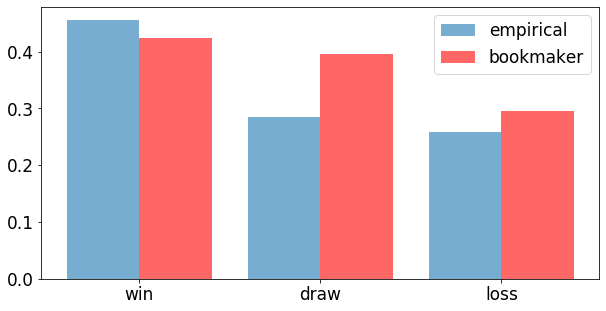

In [64]:
sub_data = feature_matrix.dropna(subset=['odd_value_X'])
empirical_probs = sub_data['result_num'].value_counts(normalize=True)
bookmaker_probs = pd.Series({
    'win': (1/sub_data['odd_value_1']).mean(),
    'draw': (1/sub_data['odd_value_X']).mean(),
    'loss': (1/sub_data['odd_value_2']).mean(),
})
_x = np.arange(empirical_probs.shape[0])
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xticks(_x)
ax.set_xticklabels(bookmaker_probs.keys())
ax.bar(_x - 0.2, empirical_probs.values, alpha=0.6, label='empirical', width=0.4)
ax.bar(_x + 0.2, bookmaker_probs.values, color='red', alpha=0.6, label='bookmaker', width=0.4)
plt.legend()

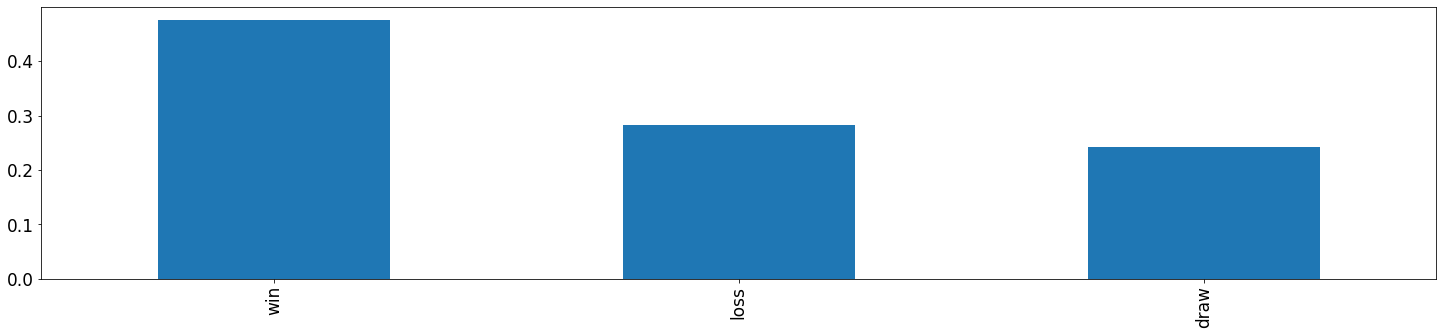

In [8]:
feature_matrix['result_num'].value_counts(normalize=True).plot(figsize=(25, 5), kind='bar')

In [65]:
assert feature_matrix.reset_index().duplicated(subset=['visitor_name', 'local_name', 'date']).sum() == 0, 'Duplicated games'

In [66]:
feature_matrix['year'] = feature_matrix.index.year

In [67]:
feature_matrix.groupby('year').size()

year
2005    170
2006    368
2007    391
2008    370
2009    370
2010    380
2011    380
2012    390
2013    380
2014    369
2015    390
2016    370
2017    390
2018    380
2019    391
2020    200
dtype: int64

In [68]:
print(f'First game with results: {feature_matrix.dropna(subset=["result_num"]).index.min().date()}')

First game with results: 2005-08-27


In [69]:
print(f'Last game with results: {feature_matrix.dropna(subset=["result_num"]).index.max().date()}')

Last game with results: 2020-02-22


## Modelling

In [70]:
from xgboost import XGBClassifier, plot_tree
from sklearn.model_selection import KFold, TimeSeriesSplit
from sklearn.metrics import classification_report, log_loss


def highest_odd_predict(features_train, target_train, features_test):
    predictions = features_test[['odd_value_1', 'odd_value_X', 'odd_value_2']]\
        .idxmax(axis=1).map({'odd_value_1': 0, 'odd_value_X': 1, 'odd_value_2': 2})
    return predictions, _

def xgboost_fit_predict(features_train, target_train, features_test, xgb, **kwargs):
    xgb.fit(features_train, target_train)
    predictions = xgb.predict(features_test)
    predictions_proba = pd.DataFrame(xgb.predict_proba(features_test), columns=xgb.classes_)
    return predictions, predictions_proba, xgb

def xgboost_fit_predict_regression(features_train, target_train, features_test, xgb, **kwargs):
    xgb.fit(features_train, target_train)
    predictions_proba = xgb.predict(features_test)
    return predictions_proba.round(), predictions_proba, xgb

def bookmaker_predict(features_test, **kwargs):
    total_odds = features_test[['odd_value_X', 'odd_value_1', 'odd_value_2']].sum(axis=1)
    total_odds.loc[total_odds == 0] = np.nan
    normalised_odds = features_test[['odd_value_1', 'odd_value_X', 'odd_value_2']]
    normalised_odds.columns = ['win', 'draw', 'loss'] # For some reason this is the mapping
    for col in normalised_odds:
        normalised_odds[col] = (1 / normalised_odds[col]) / total_odds

    return normalised_odds.idxmax(axis=1), normalised_odds, None

In [71]:
threshold = 0.2
print(f'Features with more than {threshold * 100}% missing values:')
print([f for f, v in feature_matrix.isnull().mean().iteritems() if v > threshold])

Features with more than 20.0% missing values:
['league', 'odd_value_1', 'odd_value_2', 'odd_value_X']


In [ ]:
len(feature_names)

In [72]:
from xgboost import XGBClassifier, XGBRegressor

xgb = XGBClassifier(objective='multi:softmax', num_classes=3, n_estimators=500, max_depth=6)
#xgb = XGBRegressor(n_estimators=500, max_depth=6)
print(f'Predicting with features: {sorted(feature_names)}')
predict_func = xgboost_fit_predict
splitter = TimeSeriesSplit(6)
features_to_use = feature_matrix.sort_index().dropna(subset=['result_num'])
for i, (train_ix, test_ix) in enumerate(splitter.split(features_to_use)):
    features_train, target_train = features_to_use.iloc[train_ix][feature_names], features_to_use.iloc[train_ix][target_name]
    features_test, target_test = features_to_use.iloc[test_ix][feature_names], features_to_use.iloc[test_ix][target_name]
    predictions, predictions_proba, model = predict_func(
        features_train=features_train,
        target_train=target_train,
        features_test=features_test,
        xgb=xgb
    )
    print(f'Accuracy: {round(np.mean(predictions == target_test.values), 2)}')
    print(f'log-loss: {round(log_loss(target_test.values, predictions_proba), 2)}')
    print(classification_report(target_test.values.reshape(-1), predictions, target_names=['win', 'draw', 'loss']))

Predicting with features: ['difference_in_draw_current_season', 'difference_in_draw_rolling_10_ewm', 'difference_in_draw_rolling_15_mean', 'difference_in_draw_rolling_5_mean', 'difference_in_games_played_current_season', 'difference_in_goals_conceded_current_season', 'difference_in_goals_conceded_current_season_lag_1', 'difference_in_goals_conceded_rolling_10_ewm', 'difference_in_goals_conceded_rolling_15_mean', 'difference_in_goals_conceded_rolling_5_mean', 'difference_in_goals_scored_current_season', 'difference_in_goals_scored_current_season_lag_1', 'difference_in_goals_scored_rolling_10_ewm', 'difference_in_goals_scored_rolling_15_mean', 'difference_in_goals_scored_rolling_5_mean', 'difference_in_points_current_season', 'difference_in_points_current_season_lag_1', 'difference_in_points_rolling_10_ewm', 'difference_in_points_rolling_15_mean', 'difference_in_points_rolling_5_mean', 'difference_in_position_end_season_lag_1', 'difference_in_win_current_season', 'difference_in_win_rolli

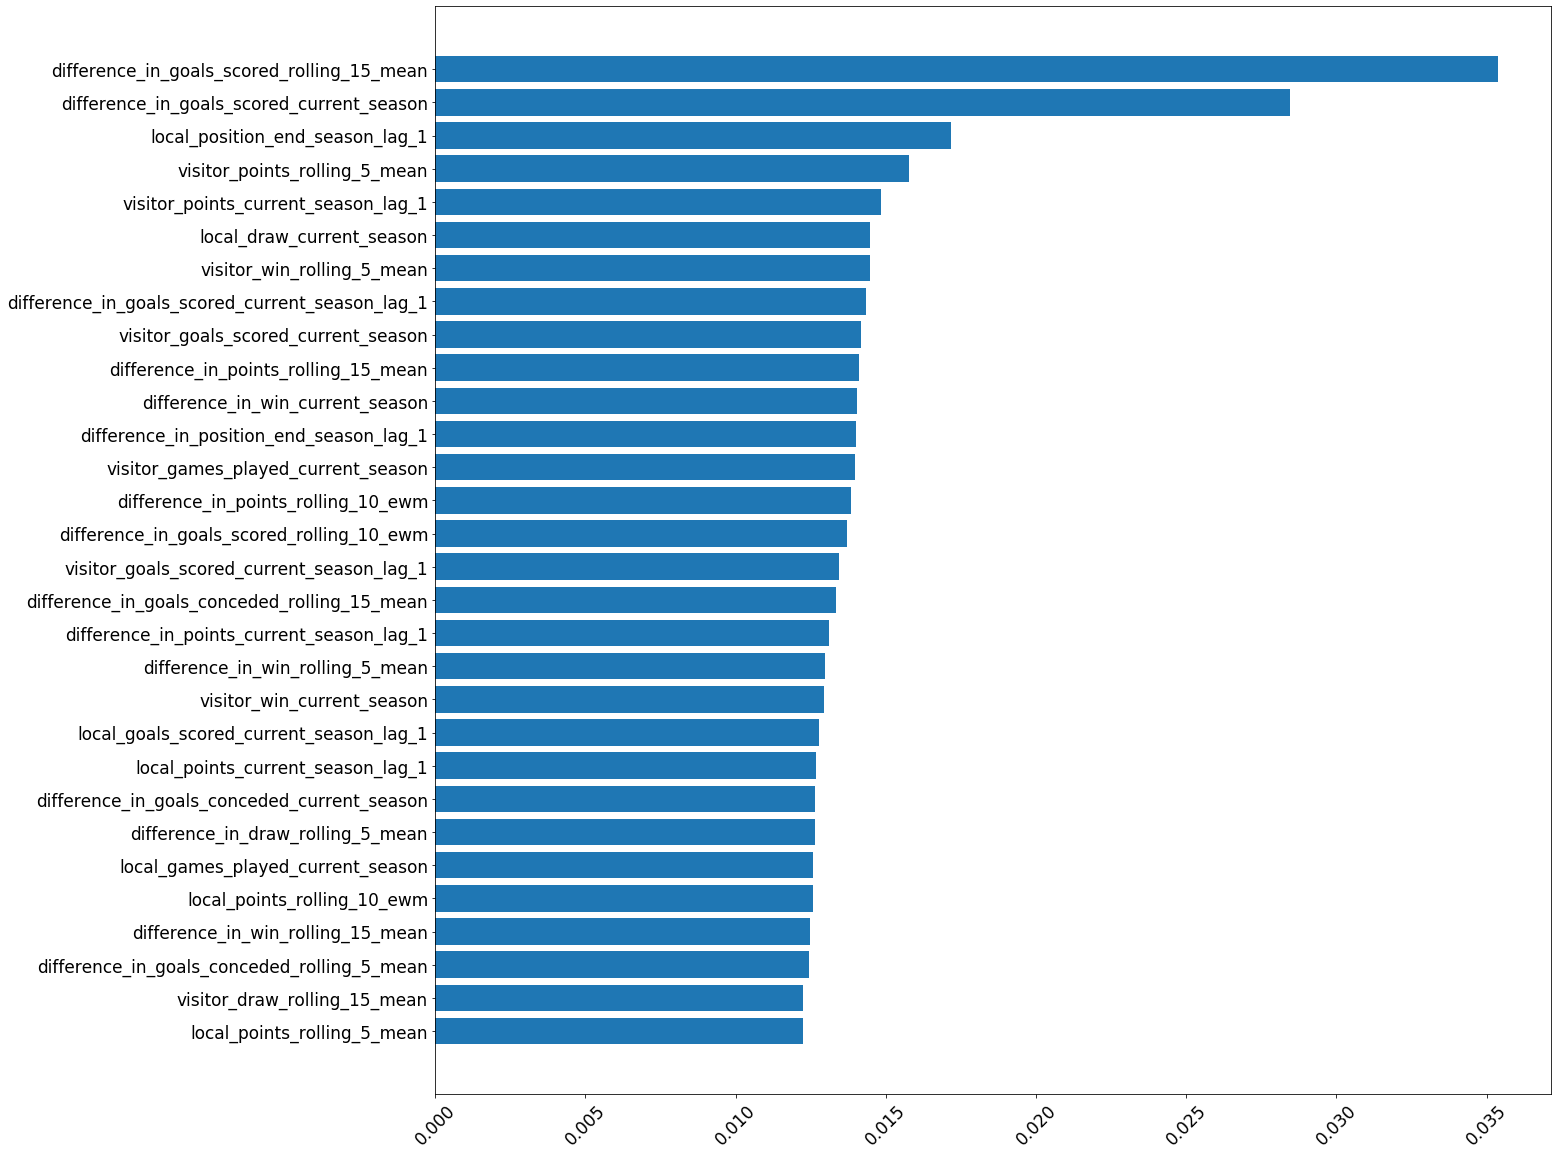

In [78]:
fig, ax = plt.subplots(figsize=(20, 20))

features_to_take = 30
feature_importances = pd.Series({f: imp for f, imp in zip(feature_names_original, model.feature_importances_)}).sort_values()
feature_names_top = feature_importances.nlargest(features_to_take).sort_values()
ax.barh(feature_names_top.index, feature_names_top.values)
feature_names = feature_names_top.keys().tolist()
feature_names = feature_names_original
plt.xticks(rotation=45)
plt.show()

In [73]:
from sklearn.model_selection import RandomizedSearchCV

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
        if i == 1:
            top_parameters = results['params'][candidate]
            
    return top_parameters   


space = {
    'learning_rate': (np.geomspace(1e-2, 1)),
    'max_depth': (range(1, 10)),
    'gamma': (np.geomspace(1e-2, 1)),
    'min_child_weight': (range(1, 10)),
    'n_estimators': (range(30, 300)),
    'reg_alpha': (np.linspace(0.2, 1)),
    'reg_lambda': (np.linspace(0.2, 2)),
}

features_to_use = feature_matrix.dropna(subset=['result_num'])
random_search = RandomizedSearchCV(XGBClassifier(objective='multi:softmax', num_classes=3, n_threads=-1), param_distributions=space,
                                   n_iter=10, cv=5, verbose=10, n_jobs=-1)
random_search.fit(features_to_use[feature_names], features_to_use[target_name])

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  4.3min remaining:   57.2s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  4.7min remaining:   18.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.0min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
       colsample_bynode=None, colsample_bytree=None, gamma=None,
       gpu_id=None, importance_type='gain', interaction_constraints=None,
       learning_rate=None, max_delta_step=None, max_depth=None,
       min_child_w...pos_weight=None, subsample=None, tree_method=None,
       validate_parameters=False, verbosity=None),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'learning_rate': array([0.01   , 0.01099, 0.01207, 0.01326, 0.01456, 0.016  , 0.01758,
       0.01931, 0.02121, 0.0233 , 0.0256 , 0.02812, 0.03089, 0.03393,
       0.03728, 0.04095, 0.04498, 0.04942, 0.05429, 0.05964, 0.06551,
       0.07197, 0.07906, 0.08685, 0.09541, 0.10481, ...39, 1.70612,
       1.74286, 1.77959, 1.81633, 1.85306, 1.8898 , 1.92653, 1.96327,
       2.     ])},
          pre_dispatch='2*n_jobs', random_state=Non

In [75]:
feature_matrix.shape

(5689, 89)

In [74]:
top_parameters = report(random_search.cv_results_)

Model with rank: 1
Mean validation score: 0.521 (std: 0.019)
Parameters: {'reg_lambda': 0.9346938775510205, 'reg_alpha': 0.9510204081632654, 'n_estimators': 126, 'min_child_weight': 7, 'max_depth': 1, 'learning_rate': 0.021209508879201904, 'gamma': 0.9102981779915218}

Model with rank: 2
Mean validation score: 0.521 (std: 0.019)
Parameters: {'reg_lambda': 1.9632653061224492, 'reg_alpha': 0.2653061224489796, 'n_estimators': 144, 'min_child_weight': 2, 'max_depth': 1, 'learning_rate': 0.028117686979742307, 'gamma': 0.6866488450042998}

Model with rank: 3
Mean validation score: 0.515 (std: 0.021)
Parameters: {'reg_lambda': 1.4122448979591837, 'reg_alpha': 0.7224489795918367, 'n_estimators': 162, 'min_child_weight': 7, 'max_depth': 1, 'learning_rate': 0.35564803062231287, 'gamma': 0.019306977288832496}



In [20]:
#top_parameters = {'reg_lambda': 0.8244897959183675, 'reg_alpha': 0.8204081632653062, 'n_estimators': 91, 'min_child_weight': 4, 'max_depth': 4, 'learning_rate': 0.010985411419875584, 'gamma': 0.025595479226995357}

In [79]:
from xgboost import XGBClassifier

xgb = XGBClassifier(objective='multi:softmax', num_classes=3, **top_parameters)
predict_func = xgboost_fit_predict
splitter = TimeSeriesSplit(6)
predictions_over_time_model = []
target_over_time =  []
for train_ix, test_ix in splitter.split(feature_matrix.dropna(subset=['result_num'])):
    features_train, target_train = feature_matrix.iloc[train_ix][feature_names], feature_matrix.iloc[train_ix][target_name]
    features_test, target_test = feature_matrix.iloc[test_ix][feature_names], feature_matrix.iloc[test_ix][target_name]
    predictions, predictions_proba, model = predict_func(features_train, target_train, features_test, xgb)
    predictions_over_time_model.append(pd.DataFrame(predictions, columns=['prediction_model'], index=features_test.index))
    target_over_time.append(target_test)
    print(f'Accuracy: {round(np.mean(predictions == target_test.values), 2)}')
    print(f'log-loss: {round(log_loss(target_test.values, predictions_proba), 2)}')
    print(classification_report(target_test.values.reshape(-1), predictions, target_names=['win', 'draw', 'loss']))
    
    
predictions_over_time_model = pd.concat(predictions_over_time_model)
target_over_time = pd.concat(target_over_time)

Accuracy: 0.51
log-loss: 1.02
              precision    recall  f1-score   support

         win       0.00      0.00      0.00       172
        draw       0.46      0.37      0.41       235
        loss       0.53      0.83      0.64       386

   micro avg       0.51      0.51      0.51       793
   macro avg       0.33      0.40      0.35       793
weighted avg       0.39      0.51      0.43       793



/Users/javiermas/py3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



Accuracy: 0.57
log-loss: 0.99
              precision    recall  f1-score   support

         win       0.00      0.00      0.00       190
        draw       0.53      0.36      0.43       198
        loss       0.58      0.93      0.71       405

   micro avg       0.57      0.57      0.57       793
   macro avg       0.37      0.43      0.38       793
weighted avg       0.43      0.57      0.47       793



/Users/javiermas/py3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



Accuracy: 0.54
log-loss: 0.98
              precision    recall  f1-score   support

         win       0.00      0.00      0.00       173
        draw       0.60      0.27      0.37       233
        loss       0.53      0.95      0.68       387

   micro avg       0.54      0.54      0.54       793
   macro avg       0.38      0.40      0.35       793
weighted avg       0.44      0.54      0.44       793



/Users/javiermas/py3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



Accuracy: 0.52
log-loss: 0.99
              precision    recall  f1-score   support

         win       0.00      0.00      0.00       193
        draw       0.54      0.34      0.42       232
        loss       0.52      0.90      0.66       368

   micro avg       0.52      0.52      0.52       793
   macro avg       0.35      0.42      0.36       793
weighted avg       0.40      0.52      0.43       793



/Users/javiermas/py3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



Accuracy: 0.53
log-loss: 0.99
              precision    recall  f1-score   support

         win       0.00      0.00      0.00       185
        draw       0.70      0.28      0.40       231
        loss       0.51      0.95      0.67       377

   micro avg       0.53      0.53      0.53       793
   macro avg       0.40      0.41      0.35       793
weighted avg       0.45      0.53      0.43       793



/Users/javiermas/py3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



Accuracy: 0.49
log-loss: 1.02
              precision    recall  f1-score   support

         win       0.00      0.00      0.00       215
        draw       0.45      0.22      0.29       210
        loss       0.49      0.92      0.64       368

   micro avg       0.49      0.49      0.49       793
   macro avg       0.31      0.38      0.31       793
weighted avg       0.35      0.49      0.38       793



/Users/javiermas/py3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



In [86]:
predictions.head()

date
2019-12-08    draw
2019-12-08    draw
2019-12-08    draw
2019-12-08    draw
2019-12-08    loss
dtype: object

In [80]:
from xgboost import XGBClassifier, XGBRegressor

predict_func = bookmaker_predict
splitter = TimeSeriesSplit(6)
features_to_use = feature_matrix.sort_index().dropna(subset=['odd_value_X', 'result_num'])
predictions_over_time_bookmaker = []
for i, (train_ix, test_ix) in enumerate(splitter.split(features_to_use)):
    features_test, target_test = features_to_use.iloc[test_ix][set(feature_names + odd_feature_names)], features_to_use.iloc[test_ix][target_name]
    predictions, predictions_proba, model = predict_func(
        features_test=features_test,
    )
    predictions = pd.DataFrame(predictions, columns=['prediction_bookmaker'])
    predictions_over_time_bookmaker.append()
    print(f'Accuracy: {round(np.mean(predictions == target_test.values), 2)}')
    print(f'log-loss: {round(log_loss(target_test.values, predictions_proba), 2)}')
    print(classification_report(target_test.values.reshape(-1), predictions, target_names=['win', 'draw', 'loss']))

predictions_over_time_bookmaker = pd.concat(predictions_over_time_bookmaker)

/Users/javiermas/py3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/javiermas/py3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Accuracy: 0.56
log-loss: 1.34
              precision    recall  f1-score   support

         win       0.51      0.58      0.55        31
        draw       0.50      0.33      0.40        18
        loss       0.62      0.65      0.63        40

   micro avg       0.56      0.56      0.56        89
   macro avg       0.54      0.52      0.53        89
weighted avg       0.56      0.56      0.56        89

Accuracy: 0.51
log-loss: 1.3
              precision    recall  f1-score   support

         win       0.29      0.45      0.36        22
        draw       0.75      0.35      0.47        26
        loss       0.60      0.63      0.62        41

   micro avg       0.51      0.51      0.51        89
   macro avg       0.55      0.48      0.48        89
weighted avg       0.57      0.51      0.51        89



/Users/javiermas/py3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/Users/javiermas/py3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



Accuracy: 0.51
log-loss: 1.3
              precision    recall  f1-score   support

         win       0.31      0.43      0.36        23
        draw       0.33      0.23      0.27        22
        loss       0.71      0.68      0.70        44

   micro avg       0.51      0.51      0.51        89
   macro avg       0.45      0.45      0.44        89
weighted avg       0.52      0.51      0.51        89

Accuracy: 0.47

/Users/javiermas/py3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy




log-loss: 1.23
              precision    recall  f1-score   support

         win       0.34      0.41      0.37        27
        draw       0.50      0.30      0.38        23
        loss       0.56      0.62      0.59        39

   micro avg       0.47      0.47      0.47        89
   macro avg       0.47      0.44      0.45        89
weighted avg       0.48      0.47      0.47        89

Accuracy: 0.51
log-loss: 1.35
              precision    recall  f1-score   support

         win       0.23      0.47      0.31        17
        draw       0.58      0.29      0.39        24
        loss       0.71      0.62      0.67        48

   micro avg       0.51      0.51      0.51        89
   macro avg       0.51      0.46      0.45        89
weighted avg       0.59      0.51      0.52        89

Accuracy: 0.48
log-loss: 1.3
              precision    recall  f1-score   support

         win       0.35      0.38      0.37        29
        draw       0.50      0.33      0.40        18


/Users/javiermas/py3/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [81]:
predictions_and_target = predictions_over_time_bookmaker.join(predictions_over_time_model).join(target_over_time).sort_index()
predictions_and_target['correct_prediction_model'] = predictions_and_target['prediction_model'] == predictions_and_target['result_num']
predictions_and_target['correct_prediction_bookmaker'] = predictions_and_target['prediction_bookmaker'] == predictions_and_target['result_num']
predictions_and_target_sum = predictions_and_target.groupby('date').sum()
predictions_and_target_avg = predictions_and_target.groupby('date').mean()

0.4633882999607381


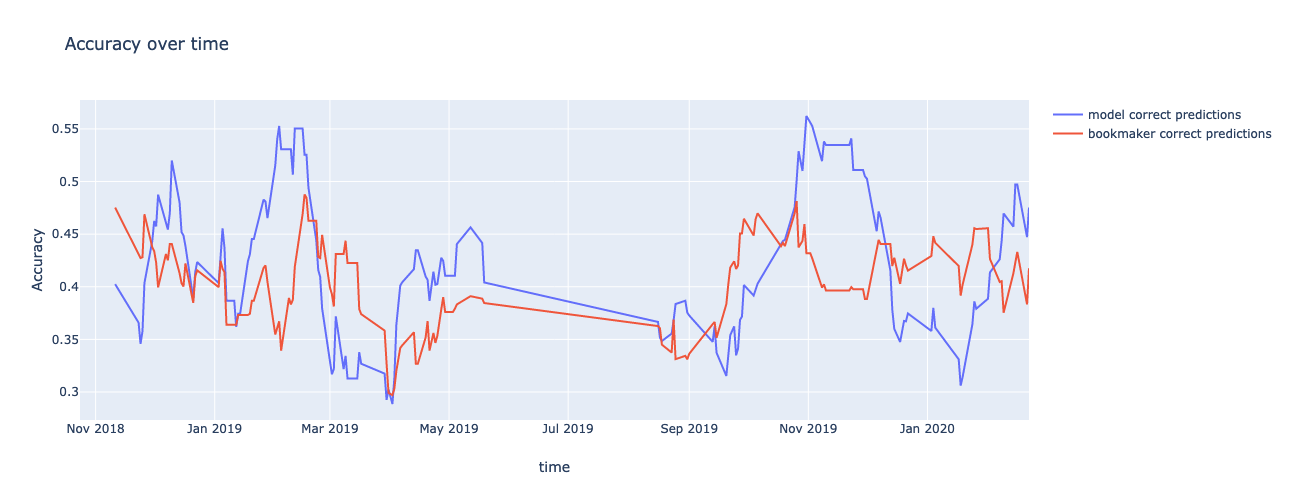

In [85]:
print(predictions_and_target['correct_prediction_model'].mean())
traces = []
scatter = go.Scatter(
    x=list(predictions_and_target_avg.index),
    y=list(predictions_and_target_avg['correct_prediction_model'].rolling(window=20, min_periods=10).mean()),
    mode='lines',
    name='model correct predictions' 
)
traces.append(scatter)
scatter = go.Scatter(
    x=list(predictions_and_target_avg.index),
    y=list(predictions_and_target_avg['correct_prediction_bookmaker'].rolling(window=20, min_periods=10).mean()),
    mode='lines',
    name='bookmaker correct predictions'
)
traces.append(scatter)

layout = {
    'title':'Accuracy over time',
    'xaxis': {
        'title': 'time',
    },
    'yaxis': {
        'title': 'Accuracy',
    },
    'width': 1300,
    'height': 500,
}
fig = go.Figure(data=traces, layout=layout)
iplot(fig)

In [84]:
predictions_and_target.head()

,prediction_bookmaker,prediction_model,result_num,correct_prediction_model,correct_prediction_bookmaker
date,,,,,
2018-10-24,loss,win,draw,False,False
2018-10-26,draw,win,draw,False,True
2018-10-27,win,win,win,True,True
2018-10-27,win,win,draw,False,False
2018-10-27,win,win,win,True,True


In [83]:
from sklearn.calibration import calibration_curve
calibration_curve(predictions_and_target['result_num'], predictions_and_target['prediction_model'])

KeyError: 'target'

## Betting

In [25]:
features_with_odds = feature_matrix.dropna(subset=['odd_value_X']).reset_index()
print(features_with_odds.shape)
features_with_odds.head()

(639, 90)


,date,local_name,visitor_name,h2h_id,result_num,visitor_games_played_current_season,local_points_rolling_10_ewm,visitor_goals_scored_rolling_15_mean,visitor_win_rolling_5_mean,local_goals_conceded_current_season_lag_1,...,difference_in_goals_scored_current_season,difference_in_goals_conceded_rolling_15_mean,difference_in_draw_current_season,difference_in_goals_scored_current_season_lag_1,difference_in_goals_conceded_rolling_5_mean,difference_in_position_end_season_lag_1,difference_in_points_rolling_5_mean,difference_in_win_current_season,difference_in_win_rolling_5_mean,year
0,2018-08-17,Girona,Real Valladolid,231_361,draw,0.0,0.755316,0.857143,0.25,58.0,...,0.0,0.571429,0.0,10.0,-0.25,-9.0,-0.75,0.0,-0.25,2018
1,2018-08-17,Real Betis,Levante,485_3457,loss,0.0,1.759943,1.500000,1.00,58.0,...,0.0,-0.428571,0.0,16.0,-0.25,-9.0,-1.75,0.0,-0.75,2018
2,2018-08-18,Celta de Vigo,Espanyol,36_528,draw,0.0,0.790050,1.000000,0.75,58.0,...,0.0,0.928571,0.0,20.0,2.50,2.0,-2.00,0.0,-0.75,2018
3,2018-08-18,Villarreal,Real Sociedad,594_3477,loss,0.0,1.871251,1.642857,0.50,48.0,...,0.0,0.500000,0.0,-11.0,0.50,-7.0,0.75,0.0,0.25,2018
4,2018-08-18,Barcelona,Deportivo Alavés,83_2975,win,0.0,1.871211,1.357143,0.75,29.0,...,0.0,0.142857,0.0,58.0,2.00,-13.0,-0.50,0.0,-0.25,2018


In [26]:
xgb = XGBClassifier(objective='multi:softmax', num_classes=3, **top_parameters)
last_training_date = features_with_odds['date'].min()
features_training = feature_matrix.loc[feature_matrix.index.get_level_values('date') < last_training_date]
xgb.fit(features_training[feature_names], features_training[target_name])

XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0.7543120063354615,
       gpu_id=-1, importance_type='gain', interaction_constraints=None,
       learning_rate=0.019306977288832496, max_delta_step=0, max_depth=2,
       min_child_weight=7, missing=nan, monotone_constraints=None,
       n_estimators=78, n_jobs=0, num_classes=3, num_parallel_tree=1,
       objective='multi:softprob', random_state=0,
       reg_alpha=0.4612244897959184, reg_lambda=1.3755102040816327,
       scale_pos_weight=None, subsample=1, tree_method=None,
       validate_parameters=False, verbosity=None)

In [27]:
def xgboost_predict(features, model):
    predictions = pd.DataFrame(model.predict_proba(features_single_date[feature_names]), columns=model.classes_)
    return predictions


def highest_odd(features, model):
    predictions = model.predict_proba(features_single_date[feature_names])
    return predictions


def get_bets_and_expected_gains(expected_value):
    bets = []
    for index, row in expected_value.iterrows():
        max_value = row.max()
        max_name = row.idxmax()
        bet = (row * 0).to_dict()
        bet[max_name] = max_value if max_value > 1.1 else 0
        bets.append(bet)
    
    bets = pd.DataFrame(bets)
    return bets, bets


def dummy_results(target):
    categories = ['win', 'draw', 'loss']
    results = pd.get_dummies(target).reset_index(drop=True)
    results = results.T.reindex(categories).T.fillna(0)
    return results
    
    
def get_returns(results, bets, odds):
    returns = pd.DataFrame(results * bets * odds, columns=results.columns)
    return returns


renaming_odd = {
    'odd_value_1': 'win',
    'odd_value_X': 'draw',
    'odd_value_2': 'loss',
}
predictions_over_time = []
money_bet = []
returns_over_time = []
train_every_n_dates = 10
features_to_use = features_with_odds.dropna(subset=['result_num'])
dates = sorted(features_to_use['date'].unique())
for i, date in enumerate(dates):
    if i % train_every_n_dates == 0:
        print(pd.Timestamp(date).date())
        features_training = feature_matrix.loc[feature_matrix.index.get_level_values('date') < date]
        xgb.fit(features_training[feature_names], features_training[target_name])
        
    features_single_date = features_to_use.loc[features_to_use['date'] == date]
    odds = features_single_date[['odd_value_1', 'odd_value_2', 'odd_value_X']].rename(columns=renaming_odd).reset_index(drop=True)
    predictions = xgboost_predict(features_single_date[feature_names], xgb)
    expected_value = odds * predictions
    bets, expected_gains = get_bets_and_expected_gains(expected_value)
    money_in_play = bets.sum().sum()
    results = dummy_results(features_single_date[target_name])
    returns = get_returns(results, bets, odds)
    total_returns_single_date = returns.sum().sum() - money_in_play
    returns_over_time.append(total_returns_single_date)
    money_bet.append(money_in_play)
    predictions = pd.DataFrame(predictions)
    predictions['local_name'] = features_single_date['local_name'].tolist()
    predictions['visitor_name'] = features_single_date['visitor_name'].tolist()
    predictions['date'] = features_single_date['date'].tolist()
    predictions_over_time.append(predictions)

print('Done')
returns_over_time = pd.Series(returns_over_time, index=dates).sort_index()
money_bet_over_time = pd.Series(money_bet, index=dates).sort_index()
predictions_over_time = pd.concat(predictions_over_time)
predictions_over_time['prediction'] = predictions_over_time[['draw', 'loss', 'win']].idxmax(axis=1)
predictions_and_features = features_to_use.set_index(['local_name', 'visitor_name', 'date']).join(
    predictions_over_time.set_index(['local_name', 'visitor_name', 'date']),
)
predictions_and_features['correct_prediction'] = predictions_and_features['result_num'] == predictions_and_features['prediction']
predictions_and_target = features_to_use.set_index(['local_name', 'visitor_name', 'date'])[[target_name]].join(
    predictions_over_time.set_index(['local_name', 'visitor_name', 'date']),
)

print(f"Accuracy over time: {(predictions_and_target.dropna()['result_num'] == predictions_and_target.dropna()['prediction']).mean()}")
print(f"log-loss over time: {log_loss(predictions_and_target['result_num'], predictions_and_target[['draw', 'loss', 'win']])}") 

2018-08-17
2018-09-02
2018-09-27
2018-10-21
2018-11-10
2018-12-07
2018-12-23
2019-01-18
2019-02-04
2019-02-23
2019-03-15
2019-04-07
2019-04-27
2019-08-17
2019-09-15
2019-10-04
2019-10-30
2019-11-29
2019-12-20
2020-01-25
2020-02-21
Done
Accuracy over time: 0.48475120385232745
log-loss over time: 1.0234706081796803


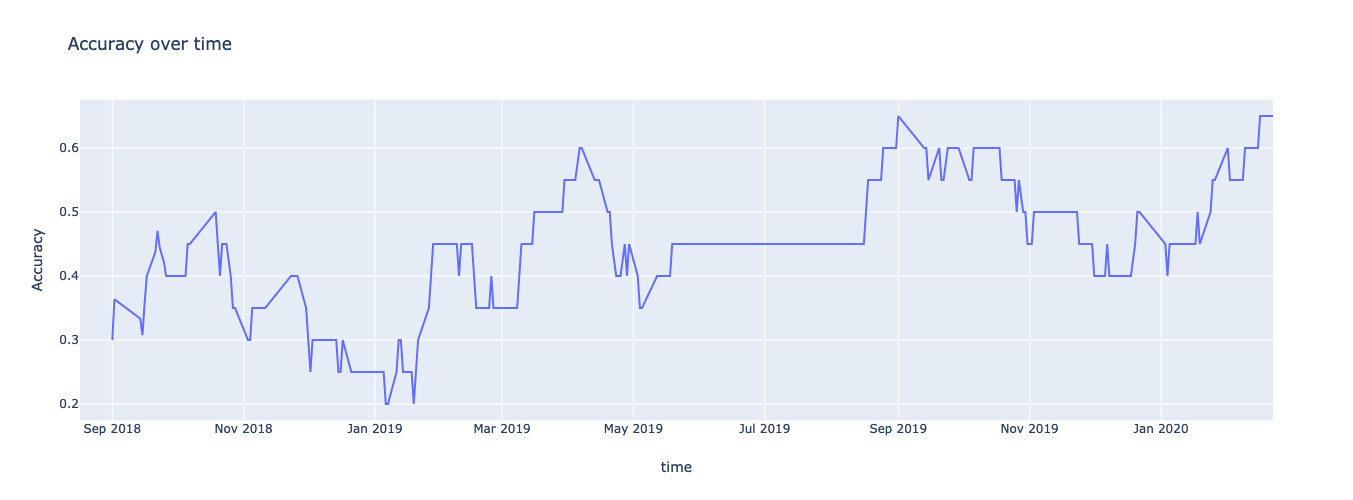

In [28]:
traces = []
scatter = go.Scatter(
    x=list(returns_over_time.index),
    y=list((predictions_and_target.dropna()['result_num'] == predictions_and_target.dropna()['prediction']).rolling(window=20, min_periods=10).mean()),
    mode='lines',
)
traces.append(scatter)

layout = {
    'title':'Accuracy over time',
    'xaxis': {
        'title': 'time',
    },
    'yaxis': {
        'title': 'Accuracy',
    },
    'width': 1300,
    'height': 500,
}
fig = go.Figure(data=traces, layout=layout)
iplot(fig)

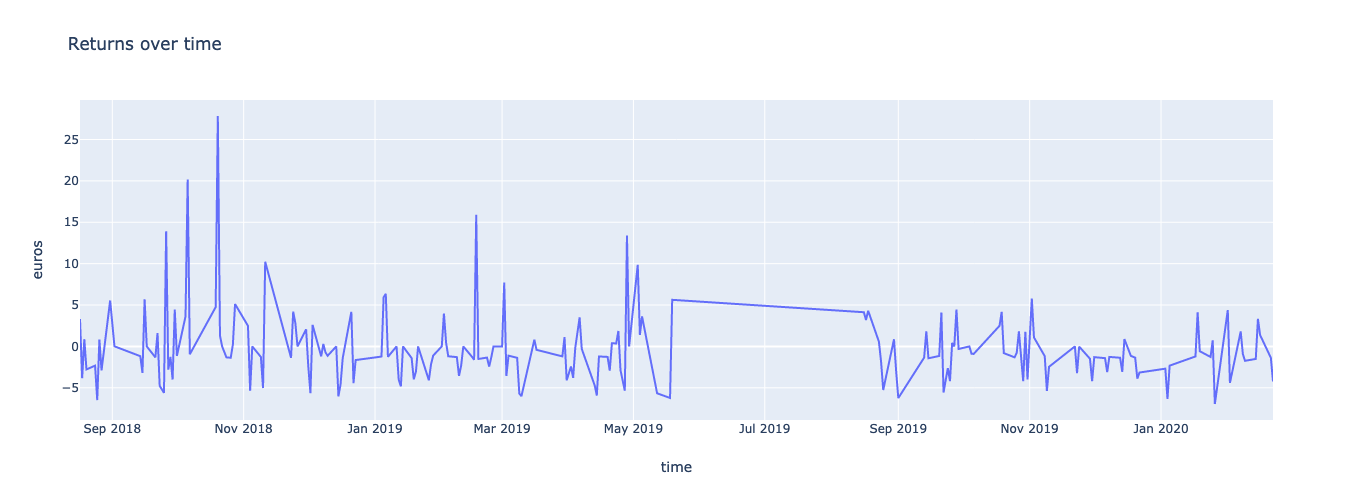

In [29]:
traces = []
scatter = go.Scatter(
    x=list(returns_over_time.keys()),
    y=list(returns_over_time.values),
    mode='lines',
)
traces.append(scatter)

layout = {
    'title':'Returns over time',
    'xaxis': {
        'title': 'time',
    },
    'yaxis': {
        'title': 'euros',
    },
    'width': 1300,
    'height': 500,
}
fig = go.Figure(data=traces, layout=layout)
iplot(fig)

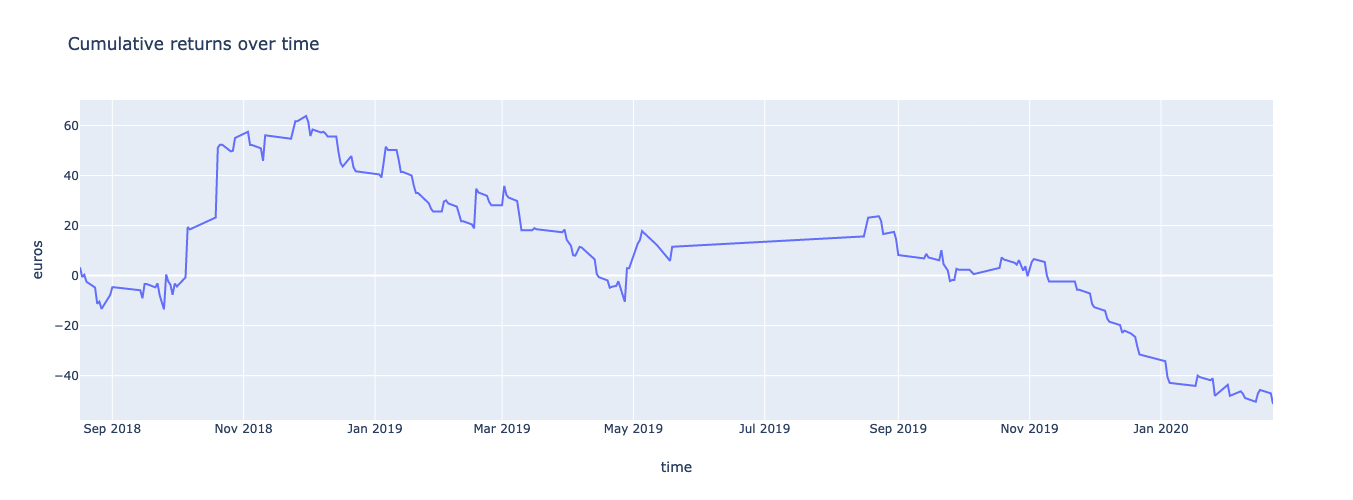

In [30]:
traces = []
scatter = go.Scatter(
    x=list(returns_over_time.keys()),
    y=list(returns_over_time.cumsum().values),
    mode='lines',
)
traces.append(scatter)

layout = {
    'title':'Cumulative returns over time',
    'xaxis': {
        'title': 'time',
    },
    'yaxis': {
        'title': 'euros',
    },
    'width': 1300,
    'height': 500,
}
fig = go.Figure(data=traces, layout=layout)
iplot(fig)

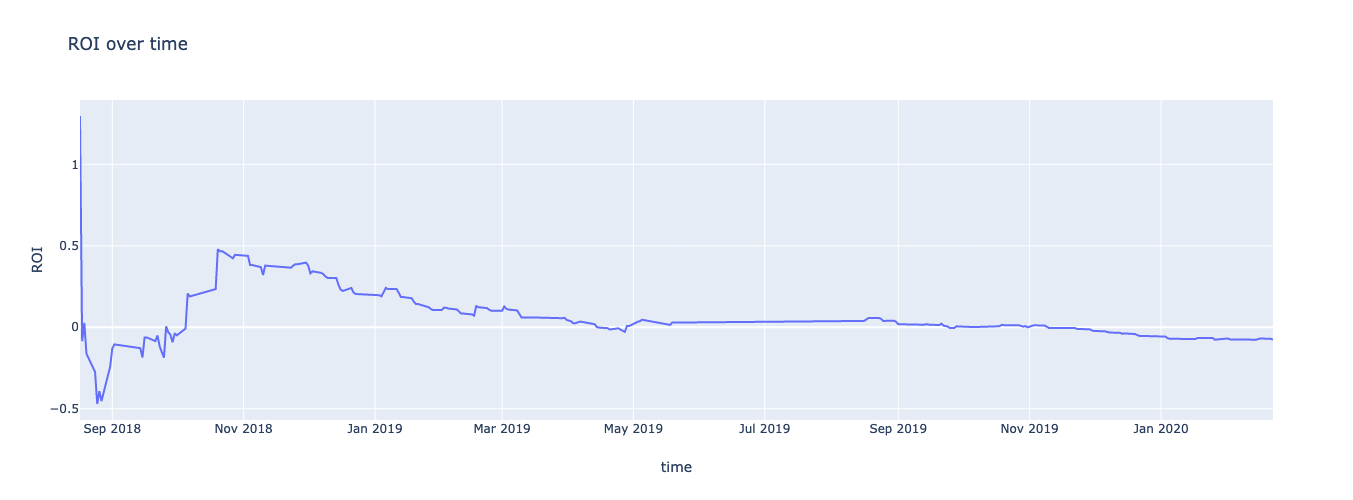

In [31]:
traces = []
scatter = go.Scatter(
    x=list(returns_over_time.keys()),
    y=list((returns_over_time.cumsum() / money_bet_over_time.cumsum()).values),
    mode='lines',
)
traces.append(scatter)

layout = {
    'title':'ROI over time',
    'xaxis': {
        'title': 'time',
    },
    'yaxis': {
        'title': 'ROI',
    },
    'width': 1300,
    'height': 500,
}
fig = go.Figure(data=traces, layout=layout)
iplot(fig)

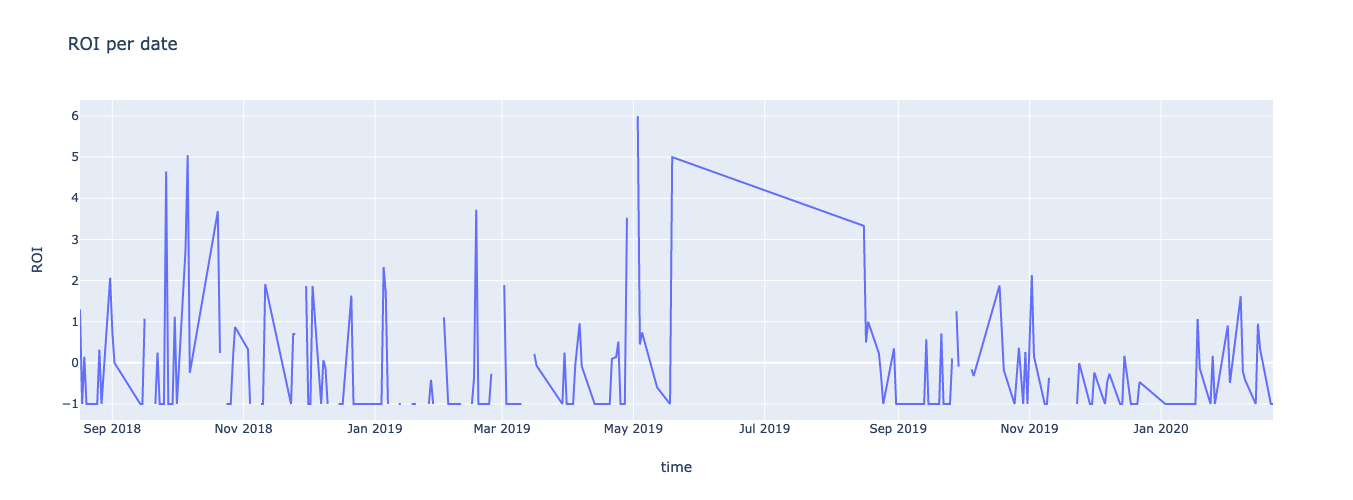

In [32]:
traces = []
scatter = go.Scatter(
    x=list(returns_over_time.keys()),
    y=list((returns_over_time / money_bet_over_time).values),
    mode='lines',
)
traces.append(scatter)

layout = {
    'title':'ROI per date',
    'xaxis': {
        'title': 'time',
    },
    'yaxis': {
        'title': 'ROI',
    },
    'width': 1300,
    'height': 500,
}
fig = go.Figure(data=traces, layout=layout)
iplot(fig)

Total returns after 207 betting days: -51.34484628143163
Median returns after 207 betting days: -1.1777111321687699
Average returns after 207 betting days: -0.25418240733381997


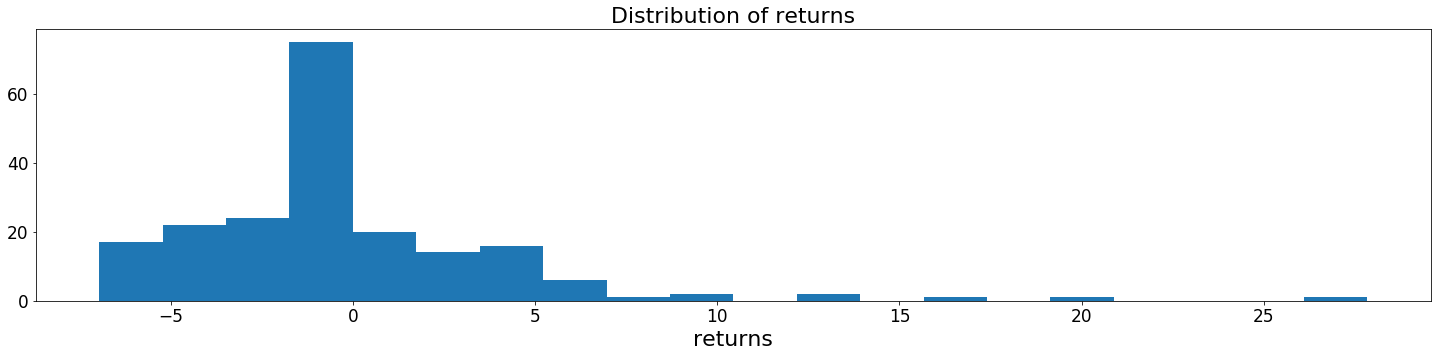

In [33]:
print(f'Total returns after {features_with_odds.date.nunique()} betting days: {np.sum(returns_over_time)}')
print(f'Median returns after {features_with_odds.date.nunique()} betting days: {np.median(returns_over_time)}')
print(f'Average returns after {features_with_odds.date.nunique()} betting days: {np.mean(returns_over_time)}')
fig, ax = plt.subplots(figsize=(25, 5))
ax.hist(returns_over_time, bins=20)
ax.set_title('Distribution of returns')
ax.set_xlabel('returns')
plt.show()

## Making bets

In [34]:
features_training.loc[features_training[target_name].isnull()].head()

,local_name,visitor_name,h2h_id,result_num,visitor_games_played_current_season,local_points_rolling_10_ewm,visitor_goals_scored_rolling_15_mean,visitor_win_rolling_5_mean,local_goals_conceded_current_season_lag_1,local_draw_rolling_5_mean,...,difference_in_goals_scored_current_season,difference_in_goals_conceded_rolling_15_mean,difference_in_draw_current_season,difference_in_goals_scored_current_season_lag_1,difference_in_goals_conceded_rolling_5_mean,difference_in_position_end_season_lag_1,difference_in_points_rolling_5_mean,difference_in_win_current_season,difference_in_win_rolling_5_mean,year
date,,,,,,,,,,,,,,,,,,,,,


In [35]:
xgb = XGBClassifier(objective='multi:softmax', num_classes=3, **top_parameters)

date = datetime.datetime(2020, 2, 23)
print(pd.Timestamp(date).date())
features_training = feature_matrix.loc[feature_matrix.index.get_level_values('date') < (date - timedelta(days=1))]
xgb.fit(features_training[feature_names], features_training[target_name])

features_single_date = features_to_use.loc[features_to_use['date'] == date]
odds = features_single_date[['odd_value_1', 'odd_value_2', 'odd_value_X']].rename(columns=renaming_odd).reset_index(drop=True)
predictions = xgboost_predict(features_single_date[feature_names], xgb)
expected_value = odds * predictions
bets, expected_gains = get_bets_and_expected_gains(expected_value)
money_in_play = bets.sum().sum()
results = dummy_results(features_single_date[target_name])
returns = get_returns(results, bets, odds)
total_returns_single_date = returns.sum().sum() - money_in_play
returns_over_time.append(total_returns_single_date)
money_bet.append(money_in_play)
predictions = pd.DataFrame(predictions)
predictions['local_name'] = features_single_date['local_name'].tolist()
predictions['visitor_name'] = features_single_date['visitor_name'].tolist()
predictions['date'] = features_single_date['date'].tolist()

2020-02-23


NameError: name 'timedelta' is not defined

In [ ]:
predictions

In [ ]:
predictions.head()

In [ ]:
predictions

In [ ]:
odds

In [ ]:
pd.concat([1/odds[['local wins', 'draw', 'visitor wins']], odds[['local_name', 'visitor_name', 'date']]], axis=1)

In [ ]:
odds

In [ ]:
feature_importances = pd.Series({f: imp for f, imp in zip(feature_names, xgb.feature_importances_)}).sort_values()
feature_names_top = feature_importances.nlargest(5).sort_values()
features_single_date[feature_names_top.index]

In [ ]:
bets

In [ ]:
expected_value

In [ ]:
## Extra: h2h analysis


In [ ]:
h2h_many_games = fixture_features.loc[fixture_features['h2h_games_played_sum'] > 5]
print(h2h_many_games.groupby('h2h_id').last()['h2h_win_mean'].max())
print(h2h_many_games.groupby('h2h_id').last()['h2h_win_mean'].idxmax())

In [ ]:
team_a = 19
team_b = 27

In [ ]:
cols_of_interest = ['name', 'h2h_goals_scored_mean', 'date', 'h2h_goals_conceded_mean', 'h2h_win_mean', 'h2h_draw_mean']
h2h_many_games.reset_index().groupby(['team_id','h2h_id']).last().loc[(team_a, f'{team_a}_{team_b}')][cols_of_interest]

In [ ]:
h2h_many_games.reset_index().groupby(['team_id','h2h_id']).last().loc[(team_b, f'{team_a}_{team_b}')][cols_of_interest]

In [ ]:
print(h2h_many_games.groupby(['team_id','h2h_id']).last()['h2h_goals_scored_mean'].max())
print(h2h_many_games.groupby(['team_id','h2h_id']).last()['h2h_goals_scored_mean'].idxmax())

In [ ]:
print(h2h_many_games.groupby(['team_id','h2h_id']).last()['h2h_goals_conceded_mean'].max())
print(h2h_many_games.groupby(['team_id','h2h_id']).last()['h2h_goals_conceded_mean'].idxmax())

In [ ]:
team_a = 9
team_b = 25

In [ ]:
cols_of_interest = ['name', 'h2h_goals_scored_mean', 'date', 'h2h_goals_conceded_mean', 'h2h_win_mean', 'h2h_draw_mean']
h2h_many_games.reset_index().groupby(['team_id','h2h_id']).last().loc[(team_a, f'{team_a}_{team_b}')][cols_of_interest]

In [ ]:
h2h_many_games.reset_index().groupby(['team_id','h2h_id']).last().loc[(team_b, f'{team_a}_{team_b}')][cols_of_interest]

In [ ]:
### Extra: odds analysis

In [ ]:
bookmaker_probabilities = 1 / fixture_features[['odd_value_1', 'odd_value_X', 'odd_value_2']].dropna()
bookmaker_probabilities = bookmaker_probabilities.sum(axis=1)

In [ ]:
bookmaker_probabilities.hist(figsize=(25, 5))